In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn import linear_model
%matplotlib inline

In [2]:
data = pd.read_csv('http://www-bcf.usc.edu/~gareth/ISL/Credit.csv', index_col=0)

In [3]:
data.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [4]:
X=data[['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education']]
Y=data['Balance']
X.head()

,Income,Limit,Rating,Cards,Age,Education
1,14.891,3606,283,2,34,11
2,106.025,6645,483,3,82,15
3,104.593,7075,514,4,71,11
4,148.924,9504,681,3,36,11
5,55.882,4897,357,2,68,16


In [5]:
# convert dummy
X_gender = pd.get_dummies(data['Gender'])
X_gender.head()

,Male,Female
1,1.0,0.0
2,0.0,1.0
3,1.0,0.0
4,0.0,1.0
5,1.0,0.0


In [6]:
X_new = pd.concat([X, X_gender['Female']], axis=1)
X_new.head()

,Income,Limit,Rating,Cards,Age,Education,Female
1,14.891,3606,283,2,34,11,0.0
2,106.025,6645,483,3,82,15,1.0
3,104.593,7075,514,4,71,11,0.0
4,148.924,9504,681,3,36,11,1.0
5,55.882,4897,357,2,68,16,0.0


Expected value for Female   529.536231884058
Expected value for Male     509.8031088082902
Is this difference statiscally signicant? 


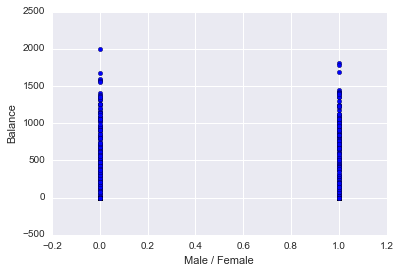

In [7]:
plt.scatter(X_new['Female'],Y)
plt.ylabel('Balance')
plt.xlabel('Male / Female')

print ('Expected value for Female   ' + str(np.mean(Y[X_new['Female']==1])))
print ('Expected value for Male     ' + str(np.mean(Y[X_new['Female']==0])))
print ('Is this difference statiscally signicant? ')

It's seems that (visually) there is not difference in Income conditing through Gender . 

In [8]:
print (str(np.mean(X_new['Female'])*100) +  '% percent of obs are Female')
print ('There is ' + str(sum(X_new['Female'])) + ' female in data set')
n_female_mean = np.mean(X_new['Female'])
n_female = sum(X_new['Female'])


51.74999999999999% percent of obs are Female
There is 207.0 female in data set


The data set can be assumed as balanced through Gender.

## The idea
we want to know if conditionating by gender, and doing a separated models for each gender we can have a significative statistical difference. So let me use the Shuflling technique to find a empirical distribution for ad hoc statiscs ( $d$ ) that tells how differents are models. 

So if we want compare models in principle we can compare betas or weights coefficients in the model of lineal regression, or score of explained variance, etc. 

---
Algorithm steps:
---
    For each simulation
        1. Normalized data in order to avoid problems with intercept 
        2. Estimate models by gender
        3. Compute statistics 
        4. Store
    

In [13]:
# First find the value of statistics for the original data
# Then, normalizing data 

gender_ori = data['Gender'] == "Female"
data_f = data[gender_ori].head()
data_m = data[~gender_ori].head()

X_m=data_m[['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education']]
Y_m=data_m['Balance']

X_f=data_f[['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education']]
Y_f=data_f['Balance']

scaler1 = preprocessing.StandardScaler().fit(X_m)
X_m = scaler1.transform(X_m)
Y_m = (Y_m - np.mean(Y_m))/np.std(Y_m)

scaler1 = preprocessing.StandardScaler().fit(X_f)
X_f = scaler1.transform(X_f)
Y_f = (Y_f - np.mean(Y_f))/np.std(Y_f)


In [15]:
# Evalueate statistics for the original data, we set alpha = 0.5 from previous analysis
# https://github.com/Torroledo/advancedComputationalMethods/blob/master/clases/semana11/Liner_Model_Regularization_LASSO.ipynb
# female  
clf_f = linear_model.Lasso(alpha=0.5)
clf_f.fit(X_f, Y_f)
# male
clf_m = linear_model.Lasso(alpha=0.5)
clf_m.fit(X_m, Y_m)

# First statistic, (difference between estimated betas)
diff_beta_ori = sum((clf_f.coef_-clf_m.coef_)**2)
    
# Second statistic (difference between scores)
diff_score_ori = (clf_f.score(X_f, Y_f)-clf_m.score(X_m, Y_m))
print (diff_beta_ori)
print (diff_score_ori)

0.0309044822458
-0.00140854911502


In [16]:
simul = 10000
n,m = X.shape 
diff_beta  = np.zeros(simul)
diff_score = np.zeros(simul)
for i in range(simul):
    # Assign aleatorily the gender
    gender = np.random.randint(0,2,n)
    
    #Normalization between groups
    selection = gender==1
    scaler1 = preprocessing.StandardScaler().fit(X[selection])
    X_f_normal = scaler1.transform(X[selection])
    Y_f_normal = (Y[selection] - np.mean(Y[selection]))/np.std(Y[selection])
        
    selection = gender==0
    scaler = preprocessing.StandardScaler().fit(X[selection])
    X_m_normal = scaler.transform(X[selection])
    Y_m_normal = (Y[selection] - np.mean(Y[selection]))/np.std(Y[selection])
    
    # female  
    clf_f = linear_model.Lasso(alpha=0.5)
    clf_f.fit(X_f_normal, Y_f_normal)
    # male
    clf_m = linear_model.Lasso(alpha=0.5)
    clf_m.fit(X_m_normal, Y_m_normal)
    
    # first statistic (sum of squared differences between betas)
    diff_beta[i] = sum((clf_f.coef_-clf_m.coef_)**2)
    
    # Second statistic (score)
    diff_score[i] = (clf_f.score(X_f_normal,Y_f_normal)-clf_m.score(X_m_normal, Y_m_normal))
    

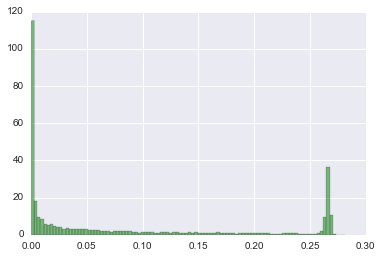

In [19]:
n, bins, patches = plt.hist(diff_beta, bins =100, normed=1.0, facecolor='green', alpha=0.5)

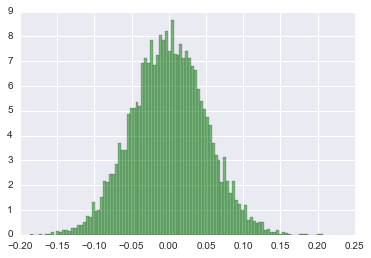

In [20]:
n, bins, patches = plt.hist(diff_score, bins =100, normed=1.0, facecolor='green', alpha=0.5)
values, base = np.histogram(diff_score, bins = 100)

---

We can see that score it is a better statistics than difference in betas because betas has a bimodal distribution. So, usinng the estimated distribution of score statistic

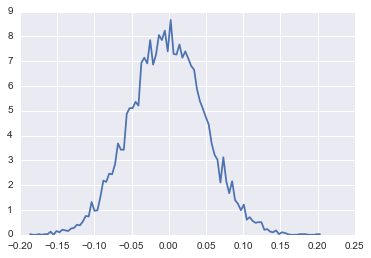

In [21]:
area = sum(values*(base[1:]-base[:-1]))
values_new = values/area

plt.plot(base[:-1],values_new)

In [24]:
print('if total area is : ' + str(area) + '  for a 0.05 of significance is ' + str(area*0.05))

if total area is : 39.3486094056  for a 0.05 of significance is 1.96743047028


In [31]:
# calculating area of statistic for orignal data 

area = sum(values[base<diff_score_ori]*(base[1:][base<diff_score_ori] -base[:-1][base<diff_score_ori]))

print(area)

19.2886883306


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 100 but corresponding boolean dimension is 101
  app.launch_new_instance()


# Conclusion 

So the area related with the score statistic for the original data is greater than area related with a p-value(0.05), then we can say that with 0.05 significance there is not difference between models that divide by gender